# Generating Figure 3b,c: Fitting Sigmoid Curve to Fc-mIL-17A CFU-E Response Data


Updated: 24/04/05

## One Parameter $E_{max}$ model
$$ \text{Activity(B(t))=} \frac{Activity_{max}}{1 + 10^{-(log_{10}(B(t))-log_{10}(EC_{50}))} } + Activity_{baseline}$$

We used the one parameter model for fit our data to determine the pharmacodynamics of each of the proteins in the context of the CFU-E data

In [5]:
import numpy as np
import pylab
from scipy.optimize import curve_fit
import matplotlib.ticker as tck
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os as os


## Define Context for Sizes
sns.set(font='Helvetica Neue',
        rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'k',
 'axes.facecolor': 'None',
 'axes.grid': False,
 'axes.labelcolor': 'k',
 'axes.spines.right': False,
 'axes.spines.top': False,
 'figure.facecolor': 'white',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'k',
 'xtick.bottom': True,
 'xtick.minor.visible': True,
 'xtick.color': 'k',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.minor.visible': True,
 'ytick.color': 'k',
 'ytick.direction': 'out',
 'ytick.left': True,
 'ytick.right': False})

sns.set_context("paper", rc={"font.size":12,
                             "axes.titlesize":16,
                             "axes.labelsize":16,
                             "xtick.labelsize":14,
                             "ytick.labelsize":14,
                            },font_scale=2)


import matplotlib.ticker as ticker

def apply_log_scale_with_custom_ticks(ax):
    """Apply log scale and custom tick settings to the given axes."""
    # Set major locator
    x_major = ticker.LogLocator(base=10.0, numticks=10)
    ax.xaxis.set_major_locator(x_major)
    
    # Set minor locator without labels
    x_minor = ticker.LogLocator(base=10.0, subs=np.arange(1.0, 10.0) * 0.1, numticks=10)
    ax.xaxis.set_minor_locator(x_minor)
    ax.xaxis.set_minor_formatter(ticker.NullFormatter())



## Data File Location:
working_path = '/Users/qiuwu/Library/CloudStorage/OneDrive-HarvardUniversity/2018-2024 PhD Work - QW/Paper Writing/FC Fusion Paper/'
figure_path = 'Figures/Figure_2_data/'
data_path = 'cfu_assay_data.csv'
data_file = working_path+figure_path+data_path


save_figures_path = "/Figures/raw_figures/figure 2/"



## Convert Doses from ng/mL to nM

In [188]:
data_df = pd.read_csv(data_file,index_col=0)

## Set multiplier to convert ng/mL to nM
multiplier_dict = {'FC Fusion': 0.0116,
                   'Commercial':0.0333,
                  }
data_df.loc[:,'Dose'] = [multiplier_dict[i] for i in data_df.loc[:,'Note']] * data_df.loc[:,'IL-17 Dose (ng/mL)']


## Model Function for Parameter Fitting

In [177]:
## Find baseline
min = data_df[(data_df.loc[:,'IL-17 Dose (ng/mL)'] == 0) & 
        (data_df.loc[:,'Note'] == 'FC Fusion') & 
        (data_df.loc[:,'Cell Origin'] =='IL17RA +/+')
].loc[:,'Colonies per Plate per million cells'].mean()

range = 1722
def sigmoid_1param(x, Ec50):
    y = (range / (1 + 10**(-(np.log10(x)-np.log10(Ec50))))) + min
    
    return y


## Parameter Fitting for 1 parameter sigmoid curves

In [204]:
## Define Data to Fit
x = data_df.loc[((data_df.loc[:,'Cell Origin']=='IL17RA +/+') &
                                     (data_df.loc[:,'Note'] == 'FC Fusion')),'Dose']
y = data_df.loc[((data_df.loc[:,'Cell Origin']=='IL17RA +/+') &
                                     (data_df.loc[:,'Note'] == 'FC Fusion')),
                        'Colonies per Plate per million cells']


## Fit to Model
popt , pcov = curve_fit(sigmoid_1param,
                        x,y, 
                       bounds = [1,10]

                       )
## Obtain 95% Confidence Interval
perr = np.sqrt(np.diag(pcov))*1.96


x1 = 10**np.linspace(-5,2,100)
y1 = sigmoid_1param(x1, *popt)
y2 = sigmoid_1param(x1, *popt + perr)
y3 = sigmoid_1param(x1, *popt - perr)

## Get EC50 with 95% Confidence Intervals
print(f'EC50 for Fc-mIL-17A: {np.round(popt[0],2)} nM +/- {np.round(perr[0],2)} nM')

EC50 for Fc-mIL-17A: 1.97 nM +/- 1.17 nM


## Define Data to Plot

In [205]:
means = data_df.groupby(['Cell Origin','Note','IL-17 Dose (ng/mL)']).mean()
sem = data_df.groupby(['Cell Origin','Note','IL-17 Dose (ng/mL)']).sem()

/var/folders/6n/m295x70529xbnpr1vzrwnk1w0000gn/T/ipykernel_61540/1292792961.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  means = data_df.groupby(['Cell Origin','Note','IL-17 Dose (ng/mL)']).mean()
/var/folders/6n/m295x70529xbnpr1vzrwnk1w0000gn/T/ipykernel_61540/1292792961.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sem is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sem = data_df.groupby(['Cell Origin','Note','IL-17 Dose (ng/mL)']).sem()


## Manually Constructing the figure
The figure has alot of inset items, so this was manual constructed

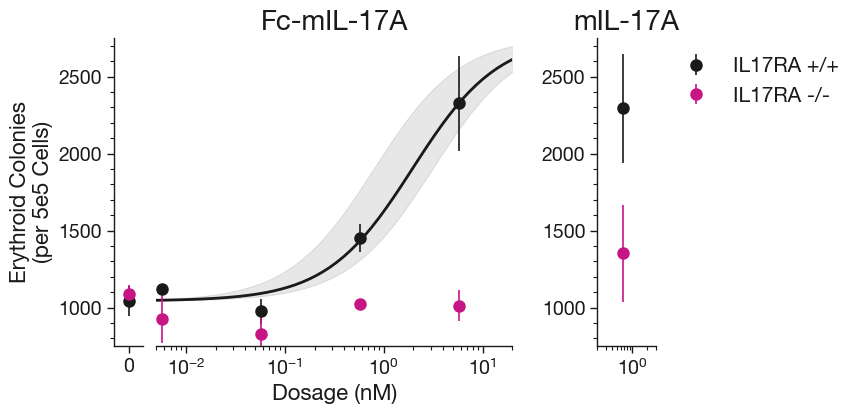

In [206]:
fig, (ax1, ax2,ax3,ax4) = plt.subplots(1, 4, 
                                   gridspec_kw={'width_ratios': [0.25, 3, 0.5,0.5]}, 
                                   figsize=(7, 4))
fig.subplots_adjust(wspace=0.1, hspace=0.5)
## First Figure
## For WT cells
ax1.errorbar(x=means.loc[('IL17RA +/+','FC Fusion')].loc[0,
             'Dose'],
                y=means.loc[('IL17RA +/+','FC Fusion')].loc[0,
             'Colonies per Plate per million cells'],
                yerr = sem.loc[('IL17RA +/+','FC Fusion')].loc[0,
             'Colonies per Plate per million cells'],
                linestyle='', color = 'k', marker='o',markersize=8)
## For KO Cells
ax1.errorbar(x=means.loc[('IL17RA -/-','FC Fusion')].loc[0,
             'Dose'],
                y=means.loc[('IL17RA -/-','FC Fusion')].loc[0,
             'Colonies per Plate per million cells'],
                yerr = sem.loc[('IL17RA -/-','FC Fusion')].loc[0,
             'Colonies per Plate per million cells'],
                linestyle='', color='mediumvioletred', marker='o',markersize=8)
ax1.set_xticks([0])
## Middle Figure
ax2.plot(x1[3:], y1[3:], color = 'k',linewidth=2)
ax2.fill_between(x1[3:], y3[3:],y1[3:], 
                alpha = 0.1,color='k')
ax2.fill_between(x1[3:], y2[3:],y1[3:], 
                alpha = 0.1,color='k')


ax2.errorbar(x=means.loc[('IL17RA +/+','FC Fusion')].loc[:,
             'Dose'],
                y=means.loc[('IL17RA +/+','FC Fusion')].loc[:,
             'Colonies per Plate per million cells'],
                yerr = sem.loc[('IL17RA +/+','FC Fusion')].loc[:,
             'Colonies per Plate per million cells'],
                linestyle='', color = 'k', marker='o',markersize=8,label = 'IL17RA +/+')
## For KO Cells
ax2.errorbar(x=means.loc[('IL17RA -/-','FC Fusion')].loc[:,
             'Dose'],
                y=means.loc[('IL17RA -/-','FC Fusion')].loc[:,
             'Colonies per Plate per million cells'],
                yerr = sem.loc[('IL17RA -/-','FC Fusion')].loc[:,
             'Colonies per Plate per million cells'],
                linestyle='', color='mediumvioletred', marker='o',markersize=8,label = 'IL17RA -/-')
ax2.set_xscale('log')
ax2.set_xlim([0.005,20])
ax2.spines['left'].set_visible(False)
ax2.set_yticks([])
ax2.set_title('Fc-mIL-17A',fontsize=20)

## Remove spin from ax3
ax3.spines['left'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax3.set_yticks([])
ax3.set_xticks([])


## End Figure
## For WT cells
ax4.errorbar(x=means.loc[('IL17RA +/+','Commercial')].loc[:,
             'Dose'],
                y=means.loc[('IL17RA +/+','Commercial')].loc[:,
             'Colonies per Plate per million cells'],
                yerr = sem.loc[('IL17RA +/+','Commercial')].loc[:,
             'Colonies per Plate per million cells'],
                linestyle='', color = 'k', marker='o',markersize=8, label = 'IL17RA +/+')
## For KO Cells
ax4.errorbar(x=means.loc[('IL17RA -/-','Commercial')].loc[:,
             'Dose'],
                y=means.loc[('IL17RA -/-','Commercial')].loc[:,
             'Colonies per Plate per million cells'],
                yerr = sem.loc[('IL17RA -/-','Commercial')].loc[:,
             'Colonies per Plate per million cells'],
                linestyle='', color='mediumvioletred', marker='o',markersize=8,label = 'IL17RA -/-')


ax4.set_xscale('log')
## Remove spin from ax4
ax4.set_title('mIL-17A',fontsize=20)

#ax4.spines['left'].set_visible(False)
#ax4.set_yticks([])
ax4.set_xlim([0.2,3])
ax4.set_xticks([1])
ax4.legend(loc='upper left',bbox_to_anchor=(1,1),fontsize=15,
           frameon=False)

ax1.set_ylabel('Erythroid Colonies\n(per 5e5 Cells)')
ax2.set_xlabel('Dosage (nM)')
apply_log_scale_with_custom_ticks(ax2)
ax1.set_ylim([750,2750])
ax2.set_ylim([750,2750])
ax4.set_ylim([750,2750])
#plt.tight_layout()
plt.savefig(working_path+save_figures_path+ f"/CFUe_Dose_Response_Curve.pdf",
            bbox_inches="tight",dpi=200)